# Konvoluční sítě pro klasifikaci

Úkolem cvičení je upravit tento notebook a dosáhnout co nejlepšího možného validačního skóre na datasetu CIFAR-10. Viz nápovědu a možné směry úprav v komentářích u jednotlivých buněk. Klasifikaci obrázků pomocí konvolučních sítí v PyTorch popisuje notebook [pytorch-convnets](lectures/pytorch-convnets.ipynb). 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import ans

## Načtení CIFAR10

In [2]:
# zlepsi predzpracovani a jine augmentace skore?
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
# augmentaci lze provadet i v testovacim rezimu
valid_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [5]:
valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=valid_transform)
valid_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
# pomuze jina batch_size?
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Kritérium

In [7]:
# muze zlepsit skore napr. SVM?
crit = nn.CrossEntropyLoss()
crit

CrossEntropyLoss()

## Definice konvoluční sítě

Síť definujte následující třídou Convnet. Není povoleno používat modely z torchvision.models ať už předtrénovanou či nepředtrénovanou verzi, ani jinou formu transfer learningu.

In [8]:
import torchvision.models as models

class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = models.resnet18()
    
    def forward(self, x):
        x = self.net.forward(x)
        
        return x

## Trénování a validace

In [9]:
# pokud vytvorime novou sit, vyresetujeme i statistiky
model = Convnet()
stats = ans.Stats()

In [10]:
device = 'cuda'
model.to(device)

Convnet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [11]:
for name, par in model.named_parameters():
    print(name, par.dtype, par.shape, par.numel())

net.conv1.weight torch.float32 torch.Size([64, 3, 7, 7]) 9408
net.bn1.weight torch.float32 torch.Size([64]) 64
net.bn1.bias torch.float32 torch.Size([64]) 64
net.layer1.0.conv1.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
net.layer1.0.bn1.weight torch.float32 torch.Size([64]) 64
net.layer1.0.bn1.bias torch.float32 torch.Size([64]) 64
net.layer1.0.conv2.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
net.layer1.0.bn2.weight torch.float32 torch.Size([64]) 64
net.layer1.0.bn2.bias torch.float32 torch.Size([64]) 64
net.layer1.1.conv1.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
net.layer1.1.bn1.weight torch.float32 torch.Size([64]) 64
net.layer1.1.bn1.bias torch.float32 torch.Size([64]) 64
net.layer1.1.conv2.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
net.layer1.1.bn2.weight torch.float32 torch.Size([64]) 64
net.layer1.1.bn2.bias torch.float32 torch.Size([64]) 64
net.layer2.0.conv1.weight torch.float32 torch.Size([128, 64, 3, 3]) 73728
net.layer2.0.bn1.wei

In [12]:
# s novou siti musime obnovit i seznam parametru pro optimizer
# lepsich vysledku obvykle dosahuje SGD s momentum
optimizer = torch.optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [13]:
# nasledujici kod libovolne upravujte

def train_step(model, batch, crit, optimizer, stats):
    # prepnout model do trenovaciho rezimu (tyka se vrstev jako Dropout nebo BatchNorm2d)
    model.train()
    
    # zajistit, aby model i data byla na stejnem zarizeni (cpu vs gpu)
    device = next(model.parameters()).device
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)
    
    # dopredny pruchod
    scores = model(inputs)

    # loss
    loss = crit(scores, targets)

    # pred zpetnym pruchodem vycistit prip. existujici gradienty z minulych iteraci
    optimizer.zero_grad()

    # zpetny pruchod, gradienty se ulozi primo do parametru modelu do atributu `grad`
    loss.backward()

    # update parametru na zaklade atributu `grad`
    optimizer.step()

    # vyhodnotime presnost
    _, pred = scores.max(dim=1)
    acc = torch.sum(pred == targets).float() / targets.shape[0]
    
    # update aktualnich statistik
    stats.append_batch_stats('train', loss=float(loss), acc=float(acc))

In [24]:
# jaky vliv ma pocet epoch?
# zkuste postupne menit learning rate (optimizer.param_groups[0]['lr'] = ...)
# nebo pomoci scheduleru (https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

for ep in range(1):
    stats.new_epoch()
    optimizer.param_groups[0]['lr'] = 0.000125
    print("optimzer lr: ", optimizer.param_groups[0]['lr'])
    
    # trenovaci faze
    pb = tqdm.auto.tqdm(train_loader, desc='epoch {:02d} train'.format(ep+1))
    for inputs, targets in pb:
        train_step(model, (inputs, targets), crit, optimizer, stats)
        
        pb.set_postfix(
            loss='{:.3f}'.format(stats.ravg('train', 'loss')),
            acc='{:.3f}'.format(stats.ravg('train', 'acc'))
        )
    
    # validacni faze
    ans.validate(model, crit, valid_loader, stats)
    scheduler.step()

optimzer lr:  0.000125


KeyError: 'train'

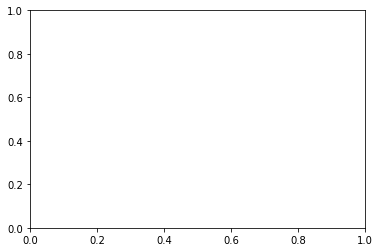

In [37]:
# nefunguje spravne, jelikoz jsem prerusoval nektere epochy...

stats.plot_by_batch(block_len=10)

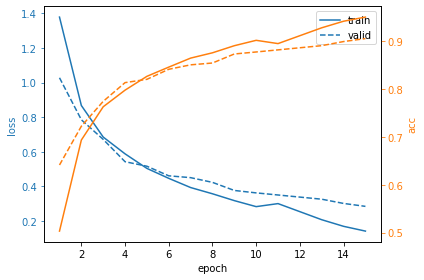

In [31]:
stats.plot_by_epoch()

In [38]:
stats.best_results()

Epoch 15,loss,acc
train,0.142398,0.950116
valid,0.285210,0.905252


## Predikce na testovacím obrázku

In [50]:
rgb_test = cv2.imread('./data/happy-green-frog.jpg')[..., ::-1]
rgb_test.dtype, rgb_test.shape, rgb_test.min(), rgb_test.max()

(dtype('uint8'), (500, 500, 3), 0, 252)

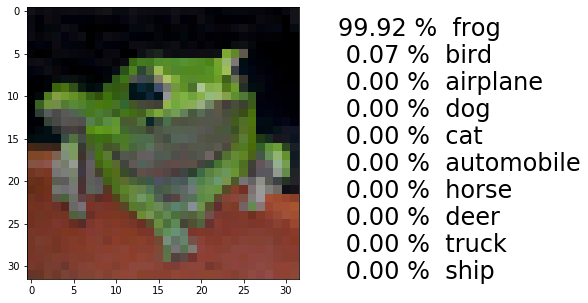

In [51]:
from PIL import Image

pil_image = Image.fromarray(cv2.resize(rgb_test, (32, 32)))

ans.predict_and_show(pil_image, model, valid_transform, classes=train_dataset.classes)